# Measure the radial velocity
This notebook interfaces with the Measure_RV.py code to measure the radial velocity of some stars. It uses the RVFitter class to do an MCMC fit.

In [45]:
#import Measure_RV
import StarData
import HelperFunctions
import Fitters
import Mamajek_Table
import SpectralTypeRelations
import matplotlib.pyplot as plt
import logging
import triangle
from astropy.io import fits
import numpy as np
import sys
import os

%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

home = os.environ['HOME']
sys.path.append('{}/School/Research/CHIRON_data/Chiron-Scripts/'.format(home))
from Search_slow import hdf5_filename

In [46]:
MT = Mamajek_Table.MamajekTable()
MS = SpectralTypeRelations.MainSequence()
sptnum2teff = MT.get_interpolator('SpTNum', 'Teff') 

def make_fitter(fname, Teff=None, logg=4.0, feh=0.0):
    orders = HelperFunctions.ReadExtensionFits(fname)
    
    if Teff is None:
        header = fits.getheader(fname)
        starname = header['OBJECT']
        SpT = StarData.GetData(starname).spectype
        Teff = sptnum2teff(MS.SpT_To_Number(SpT))

    # make sure Teff is in the grid
    hdf5_int = Fitters.StellarModel.HDF5Interface(hdf5_filename)
    grid_teffs = np.unique([d['temp'] for d in hdf5_int.list_grid_points])
    if Teff > max(grid_teffs):
        Teff = max(grid_teffs)
    #idx = np.argmin((grid_teffs - Teff)**2)
    #Teff = grid_teffs[idx]
    print(Teff)


    print(hdf5_filename)
    fitter = Fitters.RVFitter(orders[3:20], model_library=hdf5_filename, T=Teff, logg=logg, feh=feh)
    return fitter

12000
/media/ExtraSpace/PhoenixGrid/CHIRON_Grid.hdf5


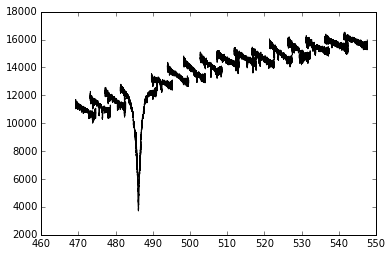

In [47]:
#reload(Measure_RV)
fitter = make_fitter('Adam_Data/20140210/HIP_53701.fits', logg=4.0)
for xi, yi in zip(fitter.x, fitter.y):
    plt.plot(xi, yi, 'k-')

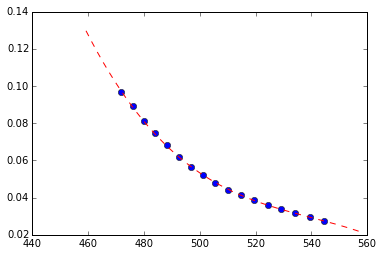

[-4.3120452963852776, 50.0, 0.5, 3235.6198723055536, 12000]


In [48]:
initial_pars = fitter.guess_fit_parameters()
#initial_pars = np.array([-7., 18., 0., 3220., 11850.])
print(initial_pars)

In [49]:
model_orders = fitter.model(initial_pars, fitter.x)
scale_factor = fitter._fit_factor(fitter.x, model_orders, fitter.y)
print(scale_factor)
#%prun fitter._fit_factor(fitter.x, model_orders, fitter.y)

[10.154378868953245, 11.241770620614091, 12.392530294067683, 13.607825025502905, 14.890675885624546, 16.242295774103923, 17.664729995751657, 19.160663541404119, 20.732308301669036, 22.380883401047868, 24.109610661031695, 25.920465960421552, 27.816154630418453, 29.798295628206063, 31.869243278593956, 34.032236047199433, 36.28975888263858]


<IPython.core.display.Javascript object>


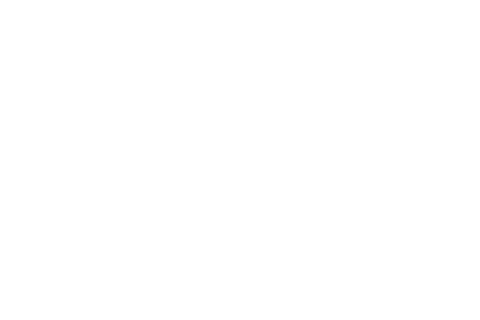

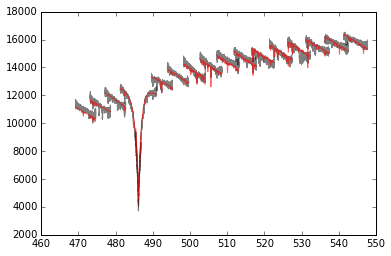

In [37]:
#orders = Measure_RV.HelperFunctions.ReadExtensionFits('20140208/HIP_50847.fits')
%matplotlib notebook
for xi, yi, model, f in zip(fitter.x, fitter.y, model_orders, scale_factor):
    
    plt.plot(xi, yi, 'k-', alpha=0.5)
    plt.plot(xi, model*f, 'r-', alpha=0.6)
#plt.show()

In [50]:
#fitter.fit(nwalkers=100, n_burn=100, n_prod=200, guess=False, initial_pars=initial_pars)
fitter.fit(backend='multinest', n_live_points=1000, basename='RVFitter/HIP53701-', overwrite=False)

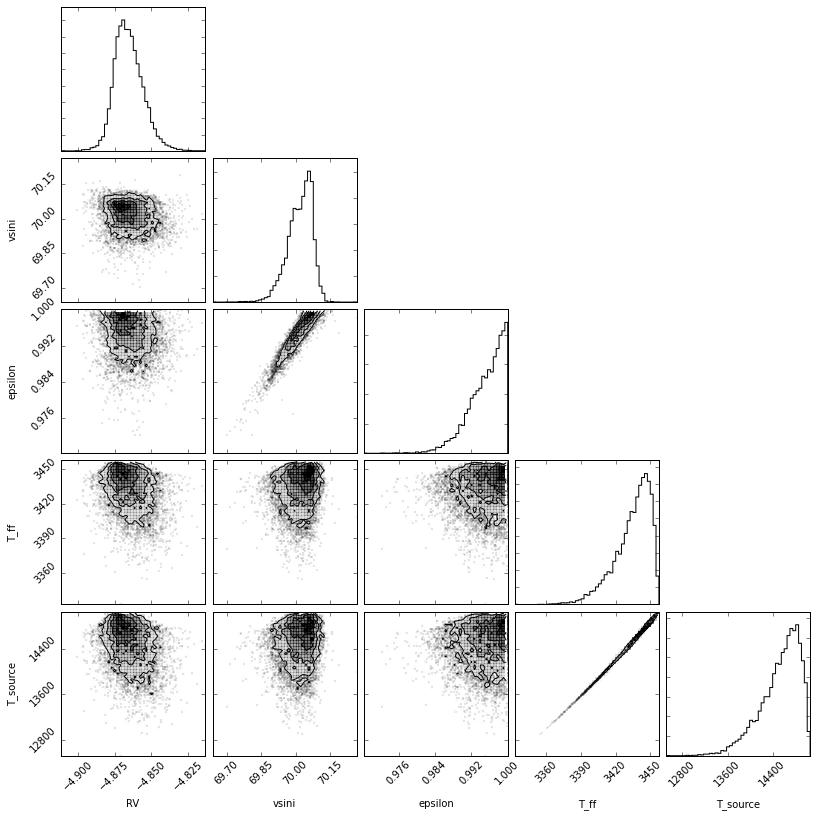

In [51]:

#samples = fitter.sampler.chain[:, 200:, :].reshape((-1, fitter.sampler.chain.shape[-1]))
#triangle.corner(samples)
fitter.triangle()

In [52]:
print fitter.samples.RV.mean(), fitter.samples.RV.std()
print fitter.samples.vsini.mean(), fitter.samples.vsini.std()

-4.86539900767 0.00980554735494
70.0182487263 0.0535284733141


(500, 520)

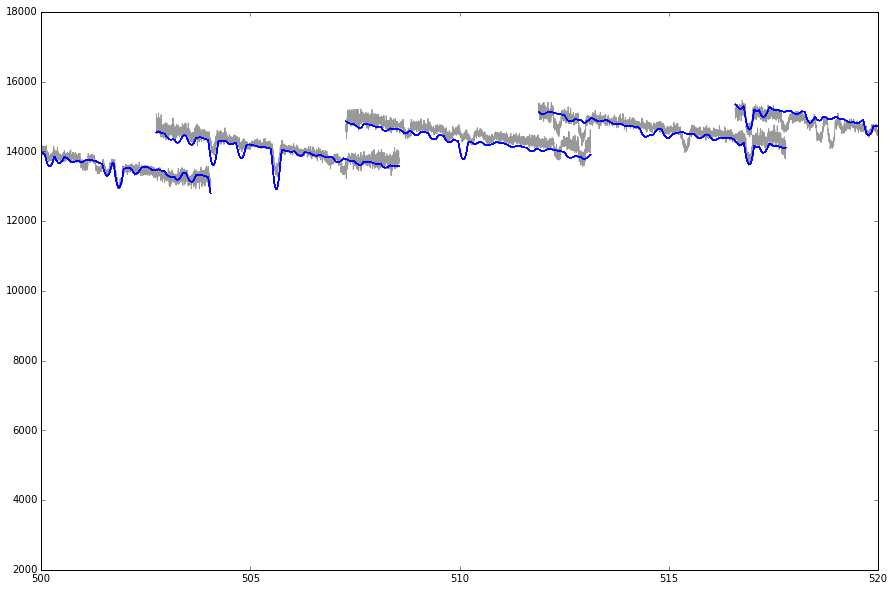

In [54]:
%matplotlib inline
plt.figure(figsize=(15, 10))
fitter.plot(alpha=0.4)
plt.xlim((500, 520))

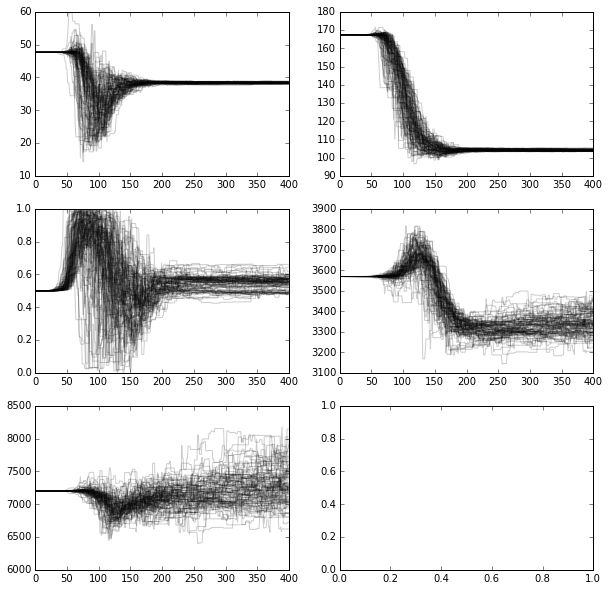

In [18]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axes = axes.flatten()
for i in range(fitter.sampler.chain.shape[-1]):
    ax = axes[i]
    _ = ax.plot(fitter.sampler.chain[:, :, i].T, 'k-', alpha=0.2)
#_ = plt.plot(fitter.sampler.chain[:, :, 0].T, 'k-', alpha=0.2)#

In [38]:
print(initial_pars)

[-13.235058325012394, 41.029072653035556, 0.5, 3304.2710854903576, 12000, -3.6150115895134648e-08, 5.798360480257152e-05, -0.031083264405581065, 5.5766214643256911]
